In [418]:
import hashlib
import os
import tarfile
import zipfile
import requests


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname



def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)


In [419]:
# 如果pandas没有被安装，请取消下一句的注释。
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


In [420]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
data_path = r'learnNotes\Action\Boston_house\data'

In [421]:
# train_data = pd.read_csv( download('kaggle_house_train'))
# test_data  = pd.read_csv( download('kaggle_house_test') )

In [422]:
train_data = pd.read_csv( '../data/kaggle_house_pred_train.csv')
test_data  = pd.read_csv( '../data/kaggle_house_pred_test.csv' )

In [423]:
print( train_data.shape ,test_data.shape)

(1460, 81) (1459, 80)


In [424]:
all_features  = pd.concat( (train_data.iloc[: , 1:-1] , test_data.iloc[: , 1:]) )

In [425]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [426]:
Numbelindex = all_features.dtypes[ all_features.dtypes != object ].index #返回的是数值型的标签所在的索引组成的列表
all_features[ Numbelindex ] = all_features[ Numbelindex ].apply( lambda X : ( X - X.mean() ) / (X.std()) )
#通过对全部特征值中的数值型特征进行提取，然后将这些变量进行归一化处理
all_features[ Numbelindex ] = all_features[ Numbelindex ].fillna( 0 )
#将一些NAN数值进行填0处理，这里一定要注意：这里取到的

In [427]:
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
# all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = pd.get_dummies(all_features , dummy_na=True)#这里对包含nan值考虑进行统一标准化
all_features.to_csv('out.csv')


In [428]:
all_features.shape

(2919, 331)

In [429]:
num_tarin = train_data.shape[0]#将训练集的数据长度赋给num_traain
train_features = torch.Tensor( all_features[:num_tarin].values )#[1460, 331]
test_features = torch.Tensor( all_features[num_tarin:].values )#[1459, 331]
# print( train_features.shape , test_features.shape ) 
train_labels = torch.Tensor(   
    train_data.SalePrice.values.reshape( -1 , 1 )#转换为一个二维张量
)

In [430]:
train_features.shape[1]

331

## 数据处理完毕，开始训练

In [431]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

class Net(torch.nn.Module):# 继承 torch 的 Module
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()     # 继承 __init__ 功能
        # 定义每层用什么样的形式
        self.layer1 = nn.Sequential(    nn.Linear(n_feature, 600)  , 
                                        # nn.BatchNorm1d(600),
                                        nn.ReLU(True)       )
        self.layer2 = nn.Sequential(    nn.Linear(600, 1200) , 
                                        # nn.BatchNorm1d(1200),
                                        nn.ReLU(True)       )   #

        self.layer3 = torch.nn.Linear(1200, n_output)

    def forward(self, x):   # 这同时也是 Module 中的 forward 功能
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

class Net2( nn.Module ):
    def __init__( self , n_features , outputs ):
        super().__init__()     # 继承 __init__ 功能
        self.layer1 = nn.Sequential(    nn.Linear(n_features, outputs)  )
    def forward( self  , x ):
        x = self.layer1(x)
        return x 
net = Net2( in_features , 1 )


In [432]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()


In [433]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


In [434]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


In [435]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        # net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k


fold 1, train log rmse 0.120684, valid log rmse 0.120599
fold 2, train log rmse 0.117350, valid log rmse 0.129624
fold 3, train log rmse 0.116961, valid log rmse 0.126619
fold 4, train log rmse 0.119958, valid log rmse 0.119618
fold 5, train log rmse 0.116030, valid log rmse 0.134086
5-折验证: 平均训练log rmse: 0.118197, 平均验证log rmse: 0.126109


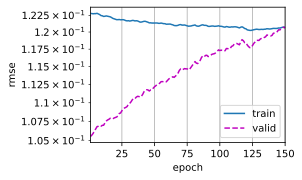

In [450]:
k, num_epochs, lr, weight_decay, batch_size = 5,150,3,0,128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
#实验了一下，发现这个三层网络还没有一层网络好用

## 我大致分析了一下这个程序与我从网上下载的程序house_py.py的区别,loss相差这么多的原因就是loss函数不一样，这里采取的kaggle的log rmse，但是那段程序就是只是mse而已，就是这个差别

In [451]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    # net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


train log rmse 0.118490


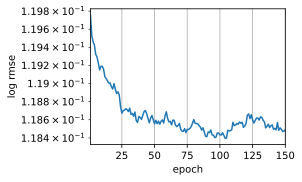

In [452]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
